In [2]:
import pyspark
from delta import *
from pyspark.sql import functions as F

builder = (
    pyspark.sql.SparkSession.builder.appName("MyApp")
    .master("local[*]")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.driver.memory", "5g")
    .config("spark.executor.memory", "5g")
    .config(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .config(
        "spark.jars.ivySettings",
        "../../ivy/2.4.0rc1.xml"
    )
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: file = ../../ivy/2.4.0rc1.xml
:: loading settings :: url = jar:file:/Users/nick.karpov/miniconda3/envs/pyspark-340-delta-240rc1/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/nick.karpov/.ivy2/cache
The jars for the packages stored in: /Users/nick.karpov/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fd79acad-55b2-4e23-846a-f8be49b631bb;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0rc1 in custom
	found io.delta#delta-storage;2.4.0rc1 in custom
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 86ms :: artifacts dl 3ms
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0   ||   3   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-fd79acad-55b2-4e23

### MiniBench: DV vs. CoW as % of files touched increases

This example will show Delete w/ Deletion Vectors vs. traditional CoW as the number of files to rewrite increases progressively to a full table rewrite

In [3]:
from pyspark.sql.functions import expr, max, col
from dataclasses import dataclass
import time

In [4]:
table_path = "/tmp/tables/dvbench"

# write a 100m rows, evenly distributed into 100 files
# add a UUID column to beef up scan time
(spark.range(0,100000000, 1, 100)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

23/05/25 12:11:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
# enable Deletion Vectors table feature
spark.sql("ALTER TABLE delta.`%s` SET TBLPROPERTIES ('delta.enableDeletionVectors' = true)" % table_path)

DataFrame[]

In [6]:
@dataclass
class TestResult:
    files_touched: int
    run: str
    elapsed: float

def get_max_id_for_files(dt, numFiles):
    return list(map(lambda x: x.id, dt.toDF().groupBy(expr("input_file_name()").alias("file"))
        .agg(max("id").alias("id"))
        .limit(numFiles).select("id")
        .collect()))

In [7]:
dt = DeltaTable.forPath(spark, table_path)
files_to_touch = [1, 15, 30, 45, 60, 75, 90, 100]
num_runs_per_scenario = 3
results = []

In [11]:
for num_files in files_to_touch:
    for run in range(0, num_runs_per_scenario):
        print("Touching {} files, run {}".format(num_files, run))
        ids = get_max_id_for_files(dt, num_files) # get id's to delete
        
        start_time = time.time_ns()
        dt.delete(
            col("id").isin(ids)
        )
        end_time = time.time_ns()
        
        elapsed = end_time - start_time
        print("Took: {}".format(elapsed))
        results.append(TestResult(files_touched=num_files, run=run, elapsed=elapsed))

        dt.restoreToVersion(1)

Touching 1 files, run 0


Took: 2036234000
Touching 1 files, run 1


Took: 1356911000
Touching 1 files, run 2


Took: 1148696000
Touching 15 files, run 0


Took: 3149326000
Touching 15 files, run 1


Took: 3003812000
Touching 15 files, run 2


Took: 2902168000
Touching 30 files, run 0


Took: 2929830000
Touching 30 files, run 1


Took: 2875466000
Touching 30 files, run 2


Took: 2769846000
Touching 45 files, run 0


Took: 3342670000
Touching 45 files, run 1


Took: 3103026000
Touching 45 files, run 2


Took: 2942694000
Touching 60 files, run 0


Took: 2895487000
Touching 60 files, run 1


Took: 2834765000
Touching 60 files, run 2


Took: 3189980000
Touching 75 files, run 0


Took: 2919213000
Touching 75 files, run 1


Took: 3109613000
Touching 75 files, run 2


Took: 2721463000
Touching 90 files, run 0


Took: 2698260000
Touching 90 files, run 1


Took: 3023621000
Touching 90 files, run 2


Took: 2772167000
Touching 100 files, run 0


Took: 2639544000
Touching 100 files, run 1


Took: 2464915000
Touching 100 files, run 2


Took: 2635821000


In [12]:
results

[TestResult(files_touched=1, run=0, elapsed=2036234000),
 TestResult(files_touched=1, run=1, elapsed=1356911000),
 TestResult(files_touched=1, run=2, elapsed=1148696000),
 TestResult(files_touched=15, run=0, elapsed=3149326000),
 TestResult(files_touched=15, run=1, elapsed=3003812000),
 TestResult(files_touched=15, run=2, elapsed=2902168000),
 TestResult(files_touched=30, run=0, elapsed=2929830000),
 TestResult(files_touched=30, run=1, elapsed=2875466000),
 TestResult(files_touched=30, run=2, elapsed=2769846000),
 TestResult(files_touched=45, run=0, elapsed=3342670000),
 TestResult(files_touched=45, run=1, elapsed=3103026000),
 TestResult(files_touched=45, run=2, elapsed=2942694000),
 TestResult(files_touched=60, run=0, elapsed=2895487000),
 TestResult(files_touched=60, run=1, elapsed=2834765000),
 TestResult(files_touched=60, run=2, elapsed=3189980000),
 TestResult(files_touched=75, run=0, elapsed=2919213000),
 TestResult(files_touched=75, run=1, elapsed=3109613000),
 TestResult(files

In [13]:
table_path = "/tmp/tables/dvbench_nodv"

# write a 100m rows, evenly distributed into 100 files
# add a UUID column to beef up scan time
(spark.range(0,100000000, 1, 100)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

In [14]:
dt = DeltaTable.forPath(spark, table_path)
files_to_touch = [1, 15, 30, 45, 60, 75, 90, 100]
num_runs_per_scenario = 3
results_nondv = []

In [15]:
for num_files in files_to_touch:
    for run in range(0, num_runs_per_scenario):
        print("Touching {} files, run {}".format(num_files, run))
        ids = get_max_id_for_files(dt, num_files) # get id's to delete
        
        start_time = time.time_ns()
        dt.delete(
            col("id").isin(ids)
        )
        end_time = time.time_ns()
        
        elapsed = end_time - start_time
        print("Took: {}".format(elapsed))
        results_nondv.append(TestResult(files_touched=num_files, run=run, elapsed=elapsed))

        dt.restoreToVersion(0)

Touching 1 files, run 0


Took: 1535278000
Touching 1 files, run 1


Took: 1326972000
Touching 1 files, run 2


Took: 1234699000
Touching 15 files, run 0


Took: 3408348000
Touching 15 files, run 1


Took: 3096041000
Touching 15 files, run 2


Took: 3148148000
Touching 30 files, run 0


Took: 4350453000
Touching 30 files, run 1


Took: 4148554000
Touching 30 files, run 2


Took: 4023096000
Touching 45 files, run 0


Took: 5583987000
Touching 45 files, run 1


Took: 5452527000
Touching 45 files, run 2


Took: 5582010000
Touching 60 files, run 0


Took: 6323857000
Touching 60 files, run 1


Took: 6245850000
Touching 60 files, run 2


Took: 6342403000
Touching 75 files, run 0


Took: 7728462000
Touching 75 files, run 1


Took: 7787085000
Touching 75 files, run 2


Took: 7628192000
Touching 90 files, run 0


Took: 8422210000
Touching 90 files, run 1


Took: 8540764000
Touching 90 files, run 2


Took: 8222059000
Touching 100 files, run 0


Took: 9277964000
Touching 100 files, run 1


Took: 9342659000
Touching 100 files, run 2


Took: 9454552000


In [53]:
import pandas as pd

# Convert to DataFrame
df_dv = pd.DataFrame([vars(result) for result in results])
df_nondv = pd.DataFrame([vars(result) for result in results_nondv])

grouped = df_dv.groupby(['files_touched'])['elapsed'].mean()
values_dv = grouped / 1e9

grouped = df_nondv.groupby(['files_touched'])['elapsed'].mean()
values_nondv = grouped / 1e9

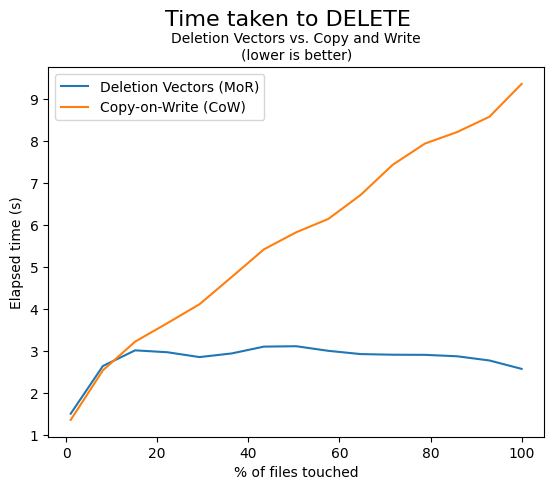

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import pandas as pd

# use pandas to munge the results
df_dv = pd.DataFrame([vars(result) for result in results])
df_nondv = pd.DataFrame([vars(result) for result in results_nondv])

# get the average of the runs
grouped = df_dv.groupby(['files_touched'])['elapsed'].mean()
values_dv = grouped / 1e9

grouped = df_nondv.groupby(['files_touched'])['elapsed'].mean()
values_nondv = grouped / 1e9

# set up the data for matplotlib
number_of_files = np.array(files_to_touch)
elapsed_time_deletion_vectors = np.array(values_dv)
elapsed_time_no_deletion_vectors = np.array(values_nondv)

# smooth the data
xnew = np.linspace(number_of_files.min(), number_of_files.max(), 15)
spline_deletion_vectors = make_interp_spline(number_of_files, elapsed_time_deletion_vectors, k=3)(xnew)
spline_no_deletion_vectors = make_interp_spline(number_of_files, elapsed_time_no_deletion_vectors, k=3)(xnew)

# plot the data
plt.plot(xnew, spline_deletion_vectors, label="Deletion Vectors (MoR)")
plt.plot(xnew, spline_no_deletion_vectors, label="Copy-on-Write (CoW)")

# make it prettier and labels
plt.xlabel("% of files touched")
plt.ylabel("Elapsed time (s)")
plt.suptitle("Time taken to DELETE", fontsize=16, y=1.0)
plt.title("Deletion Vectors vs. Copy and Write\n(lower is better)", fontsize=10)
plt.legend()

# Show the chart
plt.show()

### MiniBench: Total time DV vs. CoW as % of file deleted

In [174]:
table_path = "/tmp/tables/total"

# write 10m rows to 1 file
# add a UUID column to beef up scan time
(spark.range(0,1000000, 1, 1)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

In [175]:
# enable Deletion Vectors table feature
spark.sql("ALTER TABLE delta.`%s` SET TBLPROPERTIES ('delta.enableDeletionVectors' = true)" % table_path)

DataFrame[]

In [176]:
@dataclass
class TestResult:
    percent_file_deleted: int
    run: str
    time_to_delete: float
    time_to_read: float

In [177]:
iterations = list(range(1, 30, 2))
dt = DeltaTable.forPath(spark, table_path)
num_runs_per_scenario = 3
results = []

In [178]:
dt.history().show()

+-------+--------------------+------+--------+-----------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|        operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+-----------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      1|2023-05-25 14:38:...|  null|    null|SET TBLPROPERTIES|{properties -> {"...|null|    null|     null|          0|  Serializable|         true|                  {}|        null|Apache-Spark/3.4....|
|      0|2023-05-25 14:38:...|  null|    null|            WRITE|{mode -> ErrorIfE...|null|    null|     null|       null|  Serializable|         true|{numFiles -> 1, n...|     

In [179]:
for i in iterations:
    for run in range(0, num_runs_per_scenario):
        print("Delete {}% of file".format(i))
        start_time = time.time_ns()
        dt.delete(col("id") < ((i*10000) - 1))
        time_to_delete = time.time_ns() - start_time
        print("Took {} to delete".format(time_to_delete))

        print("Read file when {}% deleted".format(i))
        start_time = time.time_ns()
        dt.toDF().selectExpr("sum(id)").collect()
        time_to_read = time.time_ns() - start_time
        print("Took {} to read".format(time_to_read))

        results.append(TestResult(percent_file_deleted=i, run=run, time_to_delete=time_to_delete, time_to_read=time_to_read))

        dt.restoreToVersion(1)

Delete 1% of file
Took 1029464000 to delete
Read file when 1% deleted
Took 229375000 to read
Delete 1% of file
Took 1507421000 to delete
Read file when 1% deleted
Took 214438000 to read
Delete 1% of file
Took 1332893000 to delete
Read file when 1% deleted
Took 249012000 to read
Delete 3% of file
Took 1498064000 to delete
Read file when 3% deleted
Took 197498000 to read
Delete 3% of file
Took 1735530000 to delete
Read file when 3% deleted
Took 507189000 to read
Delete 3% of file
Took 1331641000 to delete
Read file when 3% deleted
Took 236737000 to read
Delete 5% of file
Took 1659024000 to delete
Read file when 5% deleted
Took 215311000 to read
Delete 5% of file
Took 1669184000 to delete
Read file when 5% deleted
Took 219057000 to read
Delete 5% of file
Took 1896491000 to delete
Read file when 5% deleted
Took 240900000 to read
Delete 7% of file
Took 2346096000 to delete
Read file when 7% deleted
Took 719660000 to read
Delete 7% of file
Took 1815074000 to delete
Read file when 7% deleted


Took 2825635000 to delete
Read file when 17% deleted
Took 519900000 to read
Delete 17% of file
Took 2323158000 to delete
Read file when 17% deleted
Took 222302000 to read
Delete 17% of file


Took 2208350000 to delete
Read file when 17% deleted
Took 367840000 to read
Delete 19% of file
Took 2902003000 to delete
Read file when 19% deleted
Took 315441000 to read
Delete 19% of file


Took 2898809000 to delete
Read file when 19% deleted
Took 256664000 to read
Delete 19% of file


Took 3257174000 to delete
Read file when 19% deleted
Took 695803000 to read
Delete 21% of file


Took 2993738000 to delete
Read file when 21% deleted
Took 336133000 to read
Delete 21% of file


Took 2653563000 to delete
Read file when 21% deleted
Took 295310000 to read
Delete 21% of file


Took 2929393000 to delete
Read file when 21% deleted
Took 306895000 to read
Delete 23% of file


Took 3068266000 to delete
Read file when 23% deleted
Took 305816000 to read
Delete 23% of file


Took 3270426000 to delete
Read file when 23% deleted
Took 686931000 to read
Delete 23% of file


Took 2816156000 to delete
Read file when 23% deleted
Took 323382000 to read
Delete 25% of file


Took 3075987000 to delete
Read file when 25% deleted
Took 215513000 to read
Delete 25% of file


Took 2983177000 to delete
Read file when 25% deleted
Took 220815000 to read
Delete 25% of file


Took 2958840000 to delete
Read file when 25% deleted
Took 271002000 to read
Delete 27% of file


Took 3375432000 to delete
Read file when 27% deleted
Took 634538000 to read
Delete 27% of file


Took 2958197000 to delete
Read file when 27% deleted
Took 224952000 to read
Delete 27% of file


Took 2943569000 to delete
Read file when 27% deleted
Took 298423000 to read
Delete 29% of file


Took 3377972000 to delete
Read file when 29% deleted
Took 244220000 to read
Delete 29% of file


Took 3190873000 to delete
Read file when 29% deleted
Took 254124000 to read
Delete 29% of file


Took 3483354000 to delete
Read file when 29% deleted
Took 572624000 to read


In [163]:
table_path = "/tmp/tables/total_nondv"

# write 10m rows to 1 file
# add a UUID column to beef up scan time
(spark.range(0,1000000, 1, 1)
     .withColumn("data", expr("uuid()"))
     .write
     .format("delta")
     .save(table_path))

In [167]:
iterations = list(range(1, 30, 2))
dt = DeltaTable.forPath(spark, table_path)
num_runs_per_scenario = 3
results_nondv = []

In [168]:
dt.history().show()

+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2023-05-25 14:31:...|  null|    null|    WRITE|{mode -> ErrorIfE...|null|    null|     null|       null|  Serializable|         true|{numFiles -> 1, n...|        null|Apache-Spark/3.4....|
+-------+--------------------+------+--------+---------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+



In [169]:
for i in iterations:
    for run in range(0, num_runs_per_scenario):
        print("Delete {}% of file".format(i))
        start_time = time.time_ns()
        dt.delete(col("id") < ((i*10000) - 1))
        time_to_delete = time.time_ns() - start_time
        print("Took {} to delete".format(time_to_delete))

        print("Read file when {}% deleted".format(i))
        start_time = time.time_ns()
        dt.toDF().selectExpr("sum(id)").collect()
        time_to_read = time.time_ns() - start_time
        print("Took {} to read".format(time_to_read))

        results_nondv.append(TestResult(percent_file_deleted=i, run=run, time_to_delete=time_to_delete, time_to_read=time_to_read))

        dt.restoreToVersion(0)

Delete 1% of file
Took 1219284000 to delete
Read file when 1% deleted
Took 146524000 to read
Delete 1% of file
Took 1546597000 to delete
Read file when 1% deleted
Took 134920000 to read
Delete 1% of file
Took 1480617000 to delete
Read file when 1% deleted
Took 136590000 to read
Delete 3% of file


Took 1481246000 to delete
Read file when 3% deleted
Took 143579000 to read
Delete 3% of file
Took 1603124000 to delete
Read file when 3% deleted
Took 145551000 to read
Delete 3% of file
Took 1445261000 to delete
Read file when 3% deleted
Took 132740000 to read
Delete 5% of file
Took 1562970000 to delete
Read file when 5% deleted
Took 149311000 to read
Delete 5% of file
Took 1612951000 to delete
Read file when 5% deleted
Took 145656000 to read
Delete 5% of file
Took 1422104000 to delete
Read file when 5% deleted
Took 135838000 to read
Delete 7% of file
Took 1602485000 to delete
Read file when 7% deleted
Took 145436000 to read
Delete 7% of file
Took 1448045000 to delete
Read file when 7% deleted
Took 139069000 to read
Delete 7% of file
Took 1567618000 to delete
Read file when 7% deleted
Took 143380000 to read
Delete 9% of file


Took 1542399000 to delete
Read file when 9% deleted
Took 143492000 to read
Delete 9% of file
Took 1486564000 to delete
Read file when 9% deleted
Took 159841000 to read
Delete 9% of file
Took 1598045000 to delete
Read file when 9% deleted
Took 143305000 to read
Delete 11% of file
Took 1502374000 to delete
Read file when 11% deleted
Took 131682000 to read
Delete 11% of file
Took 1448910000 to delete
Read file when 11% deleted
Took 148068000 to read
Delete 11% of file
Took 1594153000 to delete
Read file when 11% deleted
Took 135334000 to read
Delete 13% of file
Took 1487380000 to delete
Read file when 13% deleted
Took 141205000 to read
Delete 13% of file
Took 1437768000 to delete
Read file when 13% deleted
Took 151482000 to read
Delete 13% of file
Took 1565533000 to delete
Read file when 13% deleted
Took 153477000 to read
Delete 15% of file
Took 1522489000 to delete
Read file when 15% deleted
Took 139365000 to read
Delete 15% of file
Took 1525978000 to delete
Read file when 15% deleted
To

In [180]:
import pandas as pd

# Convert to DataFrame
df_dv = pd.DataFrame([vars(result) for result in results])
grouped = df_dv.groupby(['percent_file_deleted'])['time_to_delete'].mean()
time_to_delete = grouped / 1e9

grouped = df_dv.groupby(['percent_file_deleted'])['time_to_read'].mean()
time_to_read = grouped / 1e9

# Convert to DataFrame
df = pd.DataFrame([vars(result) for result in results_nondv])
grouped = df.groupby(['percent_file_deleted'])['time_to_delete'].mean()
time_to_delete_nondv = grouped / 1e9

grouped = df.groupby(['percent_file_deleted'])['time_to_read'].mean()
time_to_read_nondv = grouped / 1e9

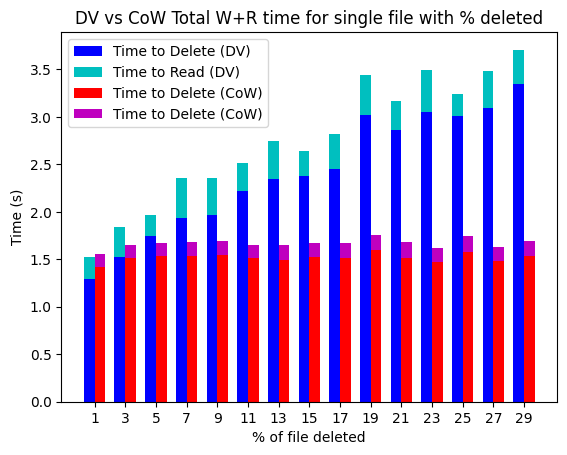

In [184]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data
categories = iterations
group_A1 = time_to_delete.to_list()
group_A2 = time_to_read.to_list()
group_B1 = time_to_delete_nondv.to_list()
group_B2 = time_to_read_nondv.to_list()

# The position of the bars on the x-axis
ind = np.arange(len(categories))

# Bar width
width = 0.35       

# Creating the figure and a single subplot
fig, ax = plt.subplots()

# Creating the bars
bar1 = ax.bar(ind - width/2, group_A1, width, color='b', label='Time to Delete (DV)')
bar2 = ax.bar(ind - width/2, group_A2, width, bottom=group_A1, color='c', label='Time to Read (DV)')
bar3 = ax.bar(ind + width/2, group_B1, width, color='r', label='Time to Delete (CoW)')
bar4 = ax.bar(ind + width/2, group_B2, width, bottom=group_B1, color='m', label='Time to Delete (CoW)')

# Adding some text for labels, title and axes ticks
ax.set_xlabel('% of file deleted')
ax.set_ylabel('Time (s)')
ax.set_title('DV vs CoW Total W+R time for single file with % deleted')
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

plt.show()